# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load and filter data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
metadata = pd.read_csv(metaPath)

acc_drop = metadata[metadata['treatment'] == 'control anti-sense molucule']["Run"].tolist()
acc_drop = [acc + "_sorted.bam" for acc in acc_drop]
df_initial.drop(columns=acc_drop, inplace=True)
metadata = metadata[metadata['treatment'] == 'chmA-KD anti-sense molucule']

In [4]:
df_initial

,Chr,Start,End,Strand,Length,SRR29325147_sorted.bam,SRR29325140_sorted.bam,SRR29325146_sorted.bam,SRR29325143_sorted.bam,SRR29325145_sorted.bam,SRR29325149_sorted.bam,SRR29325141_sorted.bam,SRR29325144_sorted.bam,SRR29325142_sorted.bam,SRR29325148_sorted.bam
Geneid,,,,,,,,,,,,,,,
gene-PA0001,NC_002516.2,483,2027,+,1545,1244,1494,1093,1853,1797,2634,1520,2572,1529,2400
gene-PA0002,NC_002516.2,2056,3159,+,1104,543,612,511,799,692,1054,730,1143,587,847
gene-PA0003,NC_002516.2,3169,4278,+,1110,1021,1394,1187,1176,1624,1344,1721,1432,1187,1526
gene-PA0004,NC_002516.2,4275,6695,+,2421,1090,1364,1112,1533,1622,1772,1853,1762,1221,1975
gene-PA0005,NC_002516.2,7018,7791,-,774,220,249,212,383,337,335,396,390,232,493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PHIKZ302,NC_004629.1,273499,273951,-,453,86,88,68,76,121,75,83,94,99,123
gene-PHIKZ303,NC_004629.1,274165,276105,-,1941,1743,1444,1442,2172,1544,2050,2050,1951,2129,2443
gene-PHIKZ304,NC_004629.1,276191,276604,-,414,143,305,120,124,516,126,156,126,149,149


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 20)
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_line,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,tissue,treatment
0,SRR29325140,RNA-Seq,101,533722178,PRJNA1121384,SAMN41750019,170894307,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"fastq,sra,run.zq","gs,ncbi,s3","s3.us-east-1,ncbi.public,gs.us-east1",SRX24841598,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314441,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314441,bacterial culture,SRP512495,bacterial culture,chmA-KD anti-sense molucule
1,SRR29325141,RNA-Seq,101,753461919,PRJNA1121384,SAMN41750020,243926897,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"fastq,sra,run.zq","s3,gs,ncbi","ncbi.public,s3.us-east-1,gs.us-east1",SRX24841597,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314440,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314440,bacterial culture,SRP512495,bacterial culture,chmA-KD anti-sense molucule
2,SRR29325142,RNA-Seq,101,603451366,PRJNA1121384,SAMN41750021,191925363,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"sra,fastq,run.zq","gs,s3,ncbi","ncbi.public,gs.us-east1,s3.us-east-1",SRX24841596,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314439,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314439,bacterial culture,SRP512495,bacterial culture,chmA-KD anti-sense molucule
3,SRR29325143,RNA-Seq,101,623633691,PRJNA1121384,SAMN41750022,201764245,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"run.zq,fastq,sra","ncbi,gs,s3","s3.us-east-1,ncbi.public,gs.us-east1",SRX24841595,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314438,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314438,bacterial culture,SRP512495,bacterial culture,chmA-KD anti-sense molucule
4,SRR29325144,RNA-Seq,101,677858773,PRJNA1121384,SAMN41750023,216049270,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"run.zq,sra,fastq","s3,ncbi,gs","ncbi.public,gs.us-east1,s3.us-east-1",SRX24841594,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314437,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:43:00Z,1,GSM8314437,bacterial culture,SRP512495,bacterial culture,chmA-KD anti-sense molucule
5,SRR29325145,RNA-Seq,101,659661603,PRJNA1121384,SAMN41750024,211706251,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"run.zq,sra,fastq","gs,ncbi,s3","s3.us-east-1,ncbi.public,gs.us-east1",SRX24841593,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314436,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314436,bacterial culture,SRP512495,bacterial culture,chmA-KD anti-sense molucule
6,SRR29325146,RNA-Seq,101,578852311,PRJNA1121384,SAMN41750025,182613726,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"sra,run.zq,fastq","ncbi,s3,gs","gs.us-east1,s3.us-east-1,ncbi.public",SRX24841592,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314435,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:45:00Z,1,GSM8314435,bacterial culture,SRP512495,bacterial culture,chmA-KD anti-sense molucule
7,SRR29325147,RNA-Seq,101,595715170,PRJNA1121384,SAMN41750026,187957528,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"sra,run.zq,fastq","s3,gs,

## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM8314432': '10_R1',  'GSM8314433': '15_R1',
              'GSM8314434': '20_R1',  'GSM8314435': '25_R1',
              'GSM8314436': '35_R1',  'GSM8314437': '10_R2',
              'GSM8314438': '15_R2',  'GSM8314439': '20_R2',
              'GSM8314440': '25_R2',  'GSM8314441': '35_R2'
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_line,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,tissue,treatment
0,SRR29325140,RNA-Seq,101,533722178,PRJNA1121384,SAMN41750019,170894307,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"fastq,sra,run.zq","gs,ncbi,s3","s3.us-east-1,ncbi.public,gs.us-east1",SRX24841598,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314441,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314441,bacterial culture,SRP512495,bacterial culture,chmA-KD anti-sense molucule


In [9]:
metadataFull.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_line,cell_type,Center Name,Collection_Date,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,genotype,geo_loc_name_country,geo_loc_name_country_continent,geo_loc_name,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,tissue,treatment,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR29325140_sorted.bam,SRR29325140,RNA-Seq,101,533722178,PRJNA1121384,SAMN41750019,170894307,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"fastq,sra,run.zq","gs,ncbi,s3","s3.us-east-1,ncbi.public,gs.us-east1",SRX24841598,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314441,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314441,bacterial culture,SRP512495,bacterial culture,chmA-KD anti-sense molucule,SRR29325140_sorted.bam,35_R2
SRR29325141_sorted.bam,SRR29325141,RNA-Seq,101,753461919,PRJNA1121384,SAMN41750020,243926897,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"fastq,sra,run.zq","s3,gs,ncbi","ncbi.public,s3.us-east-1,gs.us-east1",SRX24841597,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314440,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314440,bacterial culture,SRP512495,bacterial culture,chmA-KD anti-sense molucule,SRR29325141_sorted.bam,25_R2
SRR29325142_sorted.bam,SRR29325142,RNA-Seq,101,603451366,PRJNA1121384,SAMN41750021,191925363,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"sra,fastq,run.zq","gs,s3,ncbi","ncbi.public,gs.us-east1,s3.us-east-1",SRX24841596,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314439,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314439,bacterial culture,SRP512495,bacterial culture,chmA-KD anti-sense molucule,SRR29325142_sorted.bam,20_R2
SRR29325143_sorted.bam,SRR29325143,RNA-Seq,101,623633691,PRJNA1121384,SAMN41750022,201764245,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"run.zq,fastq,sra","ncbi,gs,s3","s3.us-east-1,ncbi.public,gs.us-east1",SRX24841595,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314438,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:44:00Z,1,GSM8314438,bacterial culture,SRP512495,bacterial culture,chmA-KD anti-sense molucule,SRR29325143_sorted.bam,15_R2
SRR29325144_sorted.bam,SRR29325144,RNA-Seq,101,677858773,PRJNA1121384,SAMN41750023,216049270,PAO1,bacteria,"JÖRG VOGEL LAB, INSTITUTE FOR MOLECULAR INFECT...",missing,public,"run.zq,sra,fastq","s3,ncbi,gs","ncbi.public,gs.us-east1,s3.us-east-1",SRX24841594,wt,uncalculated,uncalculated,missing,NextSeq 2000,GSM8314437,SINGLE,cDNA,TRANSCRIPTOMIC,Pseudomonas aeruginosa,ILLUMINA,2024-07-31T00:00:00Z,2024-06-07T18:43:00Z,1,GSM8314437,bacterial culture,SRP512495,bacterial culture,chmA-KD anti-sense molucule,SRR29325144_sorted.bam,10_R2


Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['10_R1', '10_R2',
         '15_R1', '15_R2',
         '20_R1', '20_R2',
         '25_R1', '25_R2',
         '35_R1', '35_R2']]
df.head()

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2
Geneid,,,,,,,,,,
gene-PA0001,2634,2572,2400,1853,1244,1529,1093,1520,1797,1494
gene-PA0002,1054,1143,847,799,543,587,511,730,692,612
gene-PA0003,1344,1432,1526,1176,1021,1187,1187,1721,1624,1394
gene-PA0004,1772,1762,1975,1533,1090,1221,1112,1853,1622,1364
gene-PA0005,335,390,493,383,220,232,212,396,337,249


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [11]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [12]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/NC_004629.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "NC_004629.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
5678,NC_004629.1,RefSeq,gene,164.0,553.0,.,+,.,gene-PHIKZ001,PHIKZ001,Gene,protein_coding,PHIKZ001,gene-PHIKZ001,PHIKZ001,hypothetical protein,No_PHROG,unknown function
5679,NC_004629.1,RefSeq,gene,517.0,1101.0,.,+,.,gene-PHIKZ002,PHIKZ002,Gene,protein_coding,PHIKZ002,gene-PHIKZ002,PHIKZ002,hypothetical protein,16439,unknown function
5680,NC_004629.1,RefSeq,gene,1076.0,1582.0,.,+,.,gene-PHIKZ003,PHIKZ003,Gene,protein_coding,PHIKZ003,gene-PHIKZ003,PHIKZ003,hypothetical protein,27208,unknown function
5681,NC_004629.1,RefSeq,gene,1582.0,2103.0,.,+,.,gene-PHIKZ004,PHIKZ004,Gene,protein_coding,PHIKZ004,gene-PHIKZ004,dihydrofolate reductase,dihydrofolate reductase,316,"DNA, RNA and nucleotide metabolism"
5682,NC_004629.1,RefSeq,gene,2220.0,2624.0,.,+,.,gene-PHIKZ005,PHIKZ005,Gene,protein_coding,PHIKZ005,gene-PHIKZ005,PHIKZ005,hypothetical protein,7672,unknown function
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6049,NC_004629.1,RefSeq,gene,273499.0,273951.0,.,-,.,gene-PHIKZ302,PHIKZ302,Gene,protein_coding,PHIKZ302,gene-PHIKZ302,PHIKZ302,hypothetical protein,22034,unknown function
6050,NC_004629.1,RefSeq,gene,274165.0,276105.0,.,-,.,gene-PHIKZ303,PHIKZ303,Gene,protein_coding,PHIKZ303,gene-PHIKZ303,virion structural protein,virion structural protein,24656,head and packaging
6051,NC_004629.1,RefSeq,gene,276191.0,276604.0,.,-,.,gene-PHIKZ304,PHIKZ304,Gene,protein_coding,PHIKZ304,gene-PHIKZ304,glycine zipper 2TM domain-containing protein,hypothetical protein,15869,unknown function
6052,NC_004629.1,RefSeq,gene,276601.0,277764.0,.,-,.,gene-PHIKZ305,PHIKZ305,Gene,protein_coding,PHIKZ305,gene-PHIKZ305,ribonucleotide-diphosphate reductase subunit beta,ribonucleoside diphosphate reductase small sub...,86,"DNA, RNA and nucleotide metabolism"


In [13]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'NC_002516.2', 'host', 'phage')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

In [14]:
gff3

,0,1,2,3,4,5,6,7,8,ID,GeneType,Symbol,Entity
ID,,,,,,,,,,,,,
gene-PA0001,NC_002516.2,RefSeq,gene,483.0,2027.0,.,+,.,ID=gene-PA0001;Dbxref=GeneID:878417;Name=dnaA;...,gene-PA0001,protein_coding,dnaA,host
gene-PA0002,NC_002516.2,RefSeq,gene,2056.0,3159.0,.,+,.,ID=gene-PA0002;Dbxref=GeneID:879244;Name=dnaN;...,gene-PA0002,protein_coding,dnaN,host
gene-PA0003,NC_002516.2,RefSeq,gene,3169.0,4278.0,.,+,.,ID=gene-PA0003;Dbxref=GeneID:879229;Name=recF;...,gene-PA0003,protein_coding,recF,host
gene-PA0004,NC_002516.2,RefSeq,gene,4275.0,6695.0,.,+,.,ID=gene-PA0004;Dbxref=GeneID:879230;Name=gyrB;...,gene-PA0004,protein_coding,gyrB,host
gene-PA0005,NC_002516.2,RefSeq,gene,7018.0,7791.0,.,-,.,ID=gene-PA0005;Dbxref=GeneID:877576;Name=lptA;...,gene-PA0005,protein_coding,lptA,host
...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PHIKZ302,NC_004629.1,RefSeq,gene,273499.0,273951.0,.,-,.,ID=gene-PHIKZ302;Dbxref=GeneID:1258400;Name=PH...,gene-PHIKZ302,protein_coding,None,phage
gene-PHIKZ303,NC_004629.1,RefSeq,gene,274165.0,276105.0,.,-,.,ID=gene-PHIKZ303;Dbxref=GeneID:1258398;Name=PH...,gene-PHIKZ303,protein_coding,None,phage
gene-PHIKZ304,NC_004629.1,RefSeq,gene,276191.0,276604.0,.,-,.,ID=gene-PHIKZ304;Dbxref=GeneID:1258396;Name=PH...,gene-PHIKZ304,protein_coding,None,phage


Perform in silico rRNA depletion.

In [15]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs.head()

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2
Geneid,,,,,,,,,,
gene-PA1729,122,184,164,137,87,132,108,171,172,133
gene-PA3070,143,207,222,141,102,120,116,222,185,134
gene-PA2558,215,214,282,220,195,272,242,399,473,411
gene-PA4980,27,33,23,18,10,13,11,15,9,7
gene-PA4627,178,142,140,117,114,118,99,169,180,113


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [16]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [17]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2,Entity,Symbol
Geneid,,,,,,,,,,,,
gene-PA1729,15.054930,24.587603,15.610411,18.420465,9.941488,17.392502,15.356303,18.076901,21.999693,17.339013,host,gene-PA1729
gene-PA3070,11.649319,18.266020,13.947117,12.521614,7.692601,10.448146,10.891529,15.491585,15.627066,11.539085,host,gene-PA3070
gene-PA2558,24.764622,26.729380,25.067364,27.621563,20.769778,33.446791,32.093009,39.374804,56.466293,49.975220,host,gene-PA2558
gene-PA4980,2.765191,3.652704,1.824594,2.027773,0.976073,1.449872,1.331694,1.336723,0.991291,0.796992,host,gene-PA4980
gene-PA4627,14.229525,12.318114,8.648371,10.210459,8.438365,10.089602,9.134600,11.588816,14.931872,9.561994,host,gene-PA4627
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA4538,16.043183,19.707495,11.964746,13.904302,6.670048,10.957547,11.183684,10.626531,14.563498,9.812512,host,ndh
gene-PA1765,3.653404,5.197380,3.286856,5.078568,2.571876,3.400935,3.744184,3.133393,5.252101,4.215204,host,gene-PA1765
gene-PA4516,10.003486,12.752394,7.724265,7.500183,8.887189,10.788756,11.407955,12.597408,15.343520,11.293852,host,gene-PA4516


In [18]:
# Check gene names unique
len(tpms['Symbol'].unique())

6041

Log2+1 normalization raw counts

In [19]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2,Entity,Symbol
Geneid,,,,,,,,,,,,
gene-PA1729,6.942515,7.531381,7.366322,7.108524,6.459432,7.055282,6.768184,7.426265,7.434628,7.066089,host,gene-PA1729
gene-PA3070,7.169925,7.700440,7.800900,7.149747,6.686501,6.918863,6.870365,7.800900,7.539159,7.076816,host,gene-PA3070
gene-PA2558,7.754888,7.748193,8.144658,7.787903,7.614710,8.092757,7.924813,8.643856,8.888743,8.686501,host,gene-PA2558
gene-PA4980,4.807355,5.087463,4.584963,4.247928,3.459432,3.807355,3.584963,4.000000,3.321928,3.000000,host,gene-PA4980
gene-PA4627,7.483816,7.159871,7.139551,6.882643,6.845490,6.894818,6.643856,7.409391,7.499846,6.832890,host,gene-PA4627
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA4538,8.044394,8.224002,7.994353,7.714246,6.894818,7.400879,7.321928,7.672425,7.851749,7.257388,host,ndh
gene-PA1765,5.781360,6.169925,6.000000,6.129283,5.392317,5.584963,5.614710,5.781360,6.247928,5.906891,host,gene-PA1765
gene-PA4516,6.686501,6.918863,6.686501,6.149747,6.629357,6.700440,6.672425,7.238405,7.247928,6.781360,host,gene-PA4516


Log2+1 normalization tpms

In [20]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2,Entity,Symbol
Geneid,,,,,,,,,,,,
gene-PA1729,4.004944,4.677373,4.054016,4.279506,3.451737,4.201046,4.031775,4.253755,4.523543,4.196844,host,gene-PA1729
gene-PA3070,3.660988,4.267987,3.901795,3.757196,3.119788,3.517042,3.571862,4.043658,4.055462,3.648360,host,gene-PA3070
gene-PA2558,4.687320,4.793343,4.704173,4.839031,4.444255,5.106298,5.048455,5.335383,5.844644,5.671724,host,gene-PA2558
gene-PA4980,1.912723,2.218069,1.498043,1.598257,0.982636,1.292707,1.221379,1.224487,0.993704,0.845584,host,gene-PA4980
gene-PA4627,3.928799,3.735318,3.270285,3.486773,3.238537,3.471136,3.341217,3.654071,3.993844,3.400810,host,gene-PA4627
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA4538,4.091123,4.372081,3.696522,3.897657,2.939236,3.579850,3.606878,3.539349,3.960094,3.434630,host,ndh
gene-PA1765,2.218286,2.631658,2.099920,2.603731,1.836682,2.137810,2.246160,2.047327,2.644341,2.382724,host,gene-PA1765
gene-PA4516,3.459889,3.781611,3.125034,3.087494,3.305560,3.559340,3.633193,3.765260,4.030647,3.619865,host,gene-PA4516


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [21]:
columnOrder = ['10_R1', '10_R2',
               '15_R1', '15_R2',
               '20_R1', '20_R2',
               '25_R1', '25_R2',
               '35_R1', '35_R2']

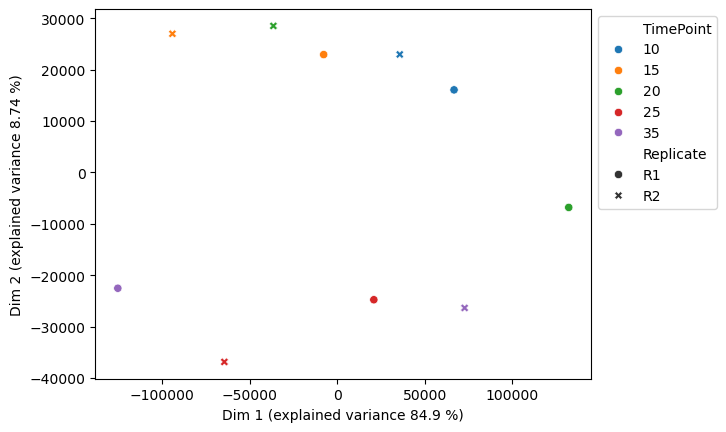

In [22]:
txPCA(tpms[columnOrder])

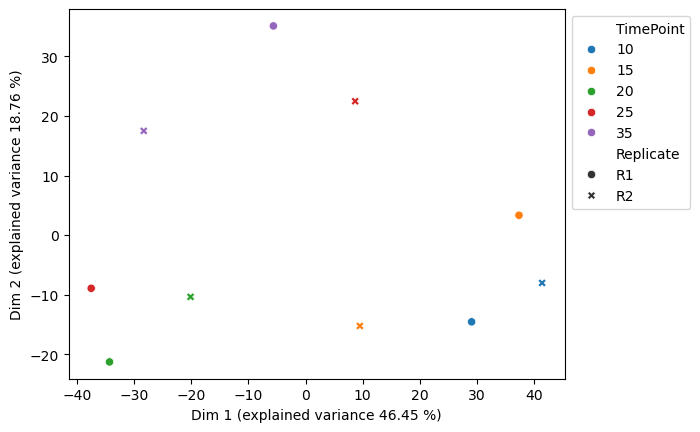

In [23]:
txPCA(logs[columnOrder])

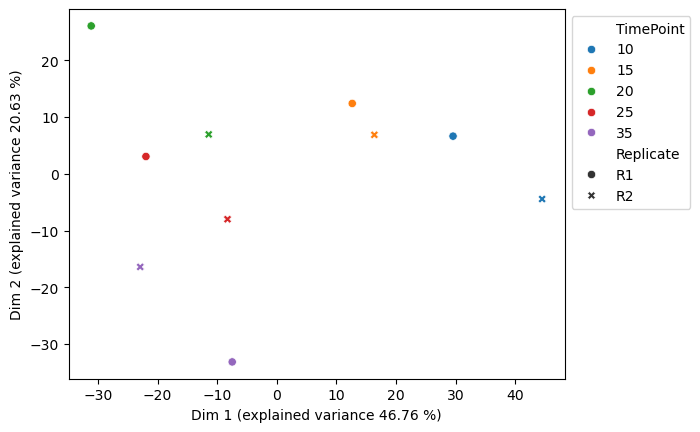

In [24]:
txPCA(logTPMs[columnOrder])

In [25]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

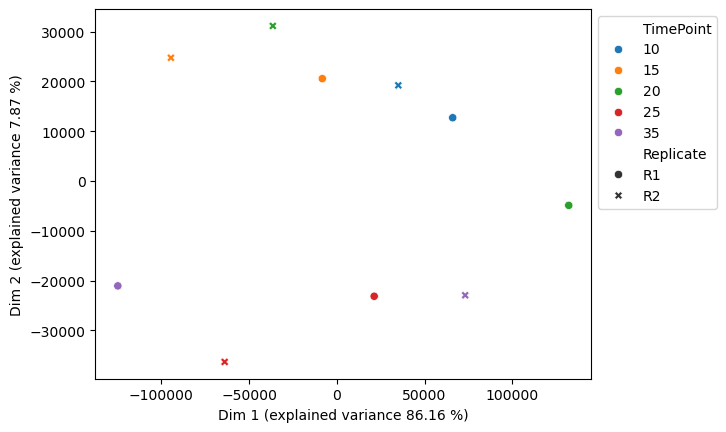

In [26]:
txPCA(tpmHost[columnOrder])

tpmPhage

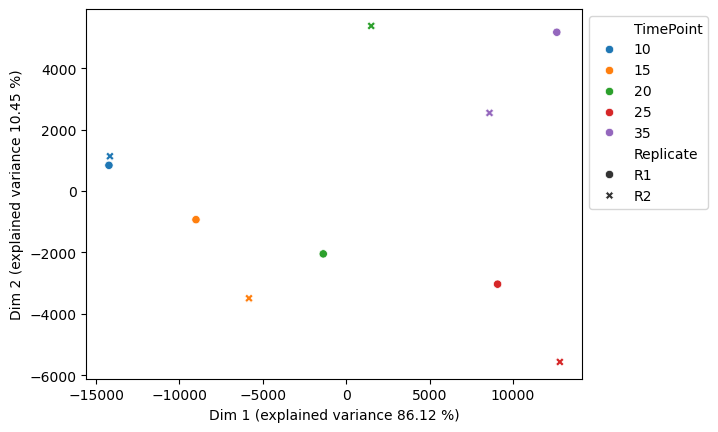

In [27]:
txPCA(tpmPhage[columnOrder])

logTPM Host

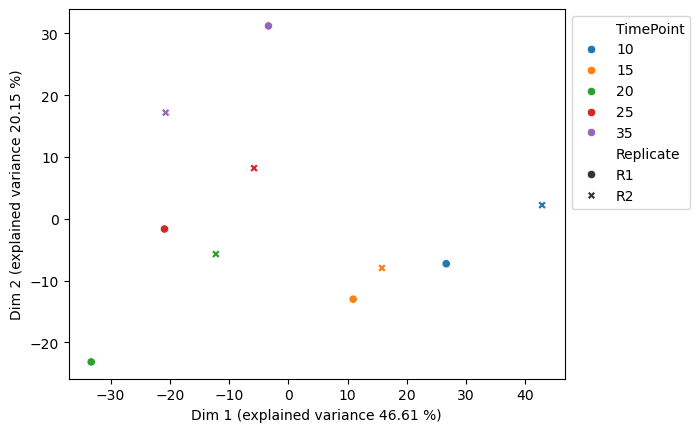

In [28]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

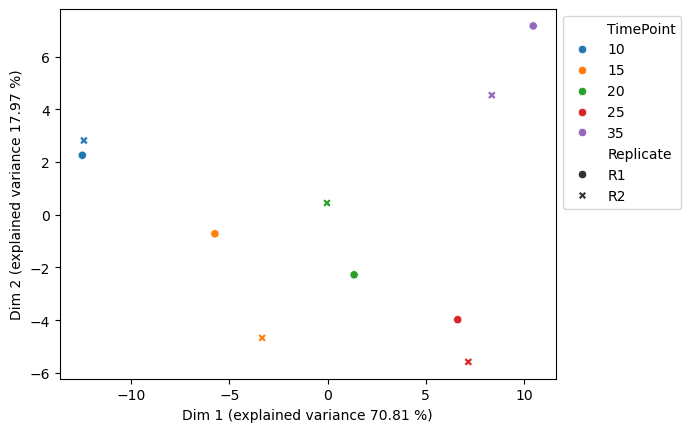

In [29]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Looks okay.

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [30]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['10', '15', '20', '25', '35']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,10,15,20,25,35,Entity,Symbol
Geneid,,,,,,,
gene-PA1729,19.821267,17.015438,13.666995,16.716602,19.669353,host,gene-PA1729
gene-PA3070,14.957670,13.234366,9.070373,13.191557,13.583076,host,gene-PA3070
gene-PA2558,25.747001,26.344464,27.108284,35.733906,53.220757,host,gene-PA2558
gene-PA4980,3.208947,1.926184,1.212973,1.334209,0.894141,host,gene-PA4980
gene-PA4627,13.273819,9.429415,9.263984,10.361708,12.246933,host,gene-PA4627
...,...,...,...,...,...,...,...
gene-PA4538,17.875339,12.934524,8.813797,10.905107,12.188005,host,ndh
gene-PA1765,4.425392,4.182712,2.986405,3.438789,4.733653,host,gene-PA1765
gene-PA4516,11.377940,7.612224,9.837972,12.002682,13.318686,host,gene-PA4516


In [31]:
TPMsds = TPMsds[['10', '15', '20', '25', '35']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,10,15,20,25,35,Entity,Symbol
Geneid,,,,,,,
gene-PA1729,4.766337,1.405027,3.725507,1.360299,2.330340,host,gene-PA1729
gene-PA3070,3.308350,0.712752,1.377773,2.300028,2.043990,host,gene-PA3070
gene-PA2558,0.982379,1.277100,6.338506,3.640898,3.245536,host,gene-PA2558
gene-PA4980,0.443756,0.101590,0.236900,0.002514,0.097149,host,gene-PA4980
gene-PA4627,0.955705,0.781044,0.825618,1.227108,2.684939,host,gene-PA4627
...,...,...,...,...,...,...,...
gene-PA4538,1.832156,0.969778,2.143750,0.278576,2.375493,host,ndh
gene-PA1765,0.771988,0.895856,0.414530,0.305396,0.518448,host,gene-PA1765
gene-PA4516,1.374454,0.112041,0.950784,0.594726,2.024834,host,gene-PA4516


In [32]:
propExp = proportionalExp(TPMmeans[['10', '15', '20', '25', '35']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,10,15,20,25,35,Entity,Symbol
Geneid,,,,,,,
gene-PA1729,1.000000,0.858444,0.689512,0.843367,0.992336,host,gene-PA1729
gene-PA3070,1.000000,0.884788,0.606403,0.881926,0.908101,host,gene-PA3070
gene-PA2558,0.483777,0.495004,0.509355,0.671428,1.000000,host,gene-PA2558
gene-PA4980,1.000000,0.600254,0.377997,0.415778,0.278640,host,gene-PA4980
gene-PA4627,1.000000,0.710377,0.697914,0.780612,0.922638,host,gene-PA4627
...,...,...,...,...,...,...,...
gene-PA4538,1.000000,0.723596,0.493070,0.610064,0.681834,host,ndh
gene-PA1765,0.934879,0.883612,0.630888,0.726456,1.000000,host,gene-PA1765
gene-PA4516,0.854284,0.571545,0.738659,0.901191,1.000000,host,gene-PA4516


## 5. Phage gene classification

In [33]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [34]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('middle')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [35]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [36]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
early     168
middle    145
late       63
Name: count, dtype: int64

Add classes to other dfs.

In [37]:
gff3_genes["seq_id"].unique()

array(['NC_002516.2', 'NC_004629.1'], dtype=object)

In [38]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'NC_002516.2']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'NC_004629.1']

## 6. Add variance to all dataframes

Base variance call on tpms.

In [39]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [40]:
tpms

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,,,,,,,,
gene-PA1729,15.054930,24.587603,15.610411,18.420465,9.941488,17.392502,15.356303,18.076901,21.999693,17.339013,host,gene-PA1729,None,None
gene-PA3070,11.649319,18.266020,13.947117,12.521614,7.692601,10.448146,10.891529,15.491585,15.627066,11.539085,host,gene-PA3070,None,None
gene-PA2558,24.764622,26.729380,25.067364,27.621563,20.769778,33.446791,32.093009,39.374804,56.466293,49.975220,host,gene-PA2558,None,None
gene-PA4980,2.765191,3.652704,1.824594,2.027773,0.976073,1.449872,1.331694,1.336723,0.991291,0.796992,host,gene-PA4980,None,None
gene-PA4627,14.229525,12.318114,8.648371,10.210459,8.438365,10.089602,9.134600,11.588816,14.931872,9.561994,host,gene-PA4627,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA4538,16.043183,19.707495,11.964746,13.904302,6.670048,10.957547,11.183684,10.626531,14.563498,9.812512,host,ndh,None,None
gene-PA1765,3.653404,5.197380,3.286856,5.078568,2.571876,3.400935,3.744184,3.133393,5.252101,4.215204,host,gene-PA1765,None,None
gene-PA4516,10.003486,12.752394,7.724265,7.500183,8.887189,10.788756,11.407955,12.597408,15.343520,11.293852,host,gene-PA4516,None,None


In [41]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,
gene-PA1729,15.054930,24.587603,15.610411,18.420465,9.941488,17.392502,15.356303,18.076901,21.999693,17.339013,host,gene-PA1729,None,None,0.821878
gene-PA3070,11.649319,18.266020,13.947117,12.521614,7.692601,10.448146,10.891529,15.491585,15.627066,11.539085,host,gene-PA3070,None,None,0.661181
gene-PA2558,24.764622,26.729380,25.067364,27.621563,20.769778,33.446791,32.093009,39.374804,56.466293,49.975220,host,gene-PA2558,None,None,3.642723
gene-PA4980,2.765191,3.652704,1.824594,2.027773,0.976073,1.449872,1.331694,1.336723,0.991291,0.796992,host,gene-PA4980,None,None,0.422100
gene-PA4627,14.229525,12.318114,8.648371,10.210459,8.438365,10.089602,9.134600,11.588816,14.931872,9.561994,host,gene-PA4627,None,None,0.430534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA4538,16.043183,19.707495,11.964746,13.904302,6.670048,10.957547,11.183684,10.626531,14.563498,9.812512,host,ndh,None,None,0.955347
gene-PA1765,3.653404,5.197380,3.286856,5.078568,2.571876,3.400935,3.744184,3.133393,5.252101,4.215204,host,gene-PA1765,None,None,0.203191
gene-PA4516,10.003486,12.752394,7.724265,7.500183,8.887189,10.788756,11.407955,12.597408,15.343520,11.293852,host,gene-PA4516,None,None,0.488767


In [42]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [43]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
df_norRNAs

SampleNames,10_R1,10_R2,15_R1,15_R2,20_R1,20_R2,25_R1,25_R2,35_R1,35_R2,Entity,Symbol
Geneid,,,,,,,,,,,,
gene-PA1729,122,184,164,137,87,132,108,171,172,133,host,gene-PA1729
gene-PA3070,143,207,222,141,102,120,116,222,185,134,host,gene-PA3070
gene-PA2558,215,214,282,220,195,272,242,399,473,411,host,gene-PA2558
gene-PA4980,27,33,23,18,10,13,11,15,9,7,host,gene-PA4980
gene-PA4627,178,142,140,117,114,118,99,169,180,113,host,gene-PA4627
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-PA4538,263,298,254,209,118,168,159,203,230,152,host,ndh
gene-PA1765,54,71,63,69,41,47,48,54,75,59,host,gene-PA1765
gene-PA4516,102,120,102,70,98,103,101,150,151,109,host,gene-PA4516


In [44]:
# Full TPM table
tpms.to_csv('Gerovac_ChmA-KD_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Gerovac_ChmA-KD_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Gerovac_ChmA-KD_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Gerovac_ChmA-KD_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Gerovac_ChmA-KD_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Gerovac_ChmA-KD_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Gerovac_ChmA-KD_phage_gff3.tsv', sep='\t')